In [1]:
# ✅ 匯入套件
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ✅ 基本參數
img_size = 128
batch_size = 32
epochs = 50
base_dir = "C:/Users/User/Python/pj2/Gender_classification"

# ✅ 載入資料並轉換性別標籤為 0/1
df = pd.read_excel(os.path.join(base_dir, "gender_detection.xlsx"))
df['gender'] = df['gender'].map({'woman': 0, 'man': 1})
train_df = df[df['split'] == 'train'].copy()
test_df = df[df['split'] == 'test'].copy()

# ✅ 圖像讀取函式
def load_images_from_df(df):
    images, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(base_dir, row['file'])
        img = load_img(img_path, target_size=(img_size, img_size))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(row['gender'])
    return np.array(images), np.array(labels)

# ✅ 載入圖像資料
x_train_all, y_train_all = load_images_from_df(train_df)
x_test, y_test = load_images_from_df(test_df)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

# ✅ 資料增強
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(x_train)

# ✅ 自建 CNN 模型（升級版）
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# ✅ Callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.002,
    restore_best_weights=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# ✅ 訓練模型
model = build_cnn()
model.summary()

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_val, y_val),
    epochs=epochs,
    steps_per_epoch=len(x_train) // batch_size,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# ✅ 模型評估
loss, acc = model.evaluate(x_test, y_test)
print(f"\n模型的測試集準確率：{acc:.4f}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 64)                8128576   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

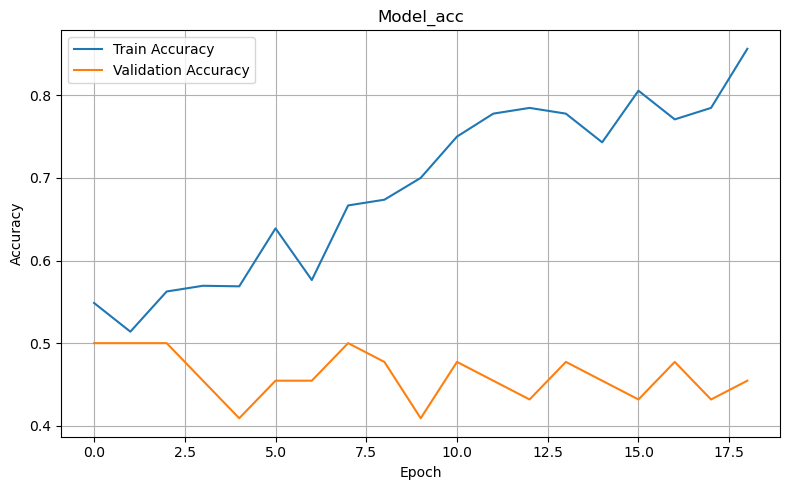

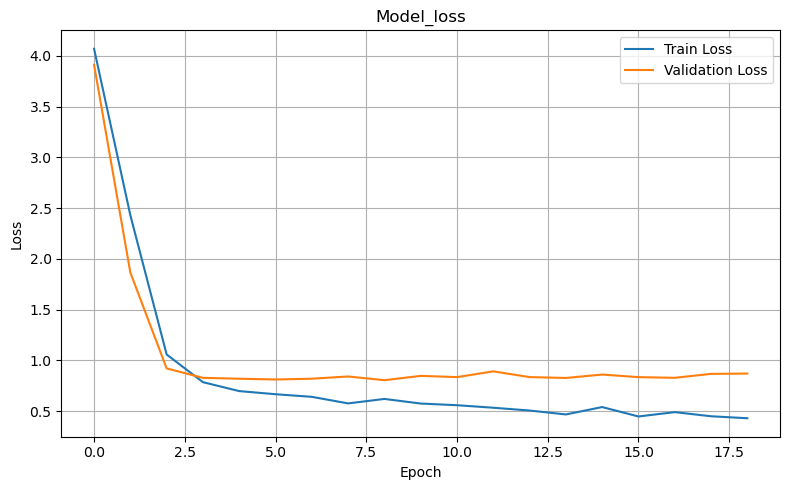

In [2]:
# 準確率圖
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 損失圖
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
